# Synthetic Backtest Report

This notebook presents synthetic ANTICOR backtest results. It summarizes key results and metrics across scenarios and strategies and renders comparison tables and plots.

In [43]:
# 1. Load Dependencies and Config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from IPython.display import display, HTML, Image

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Paths
ROOT = Path(".")
RESULTS_DIR = ROOT / "results" / "synthetic"
PLOTS_DIR = RESULTS_DIR / "plots"
CSV_PATH = RESULTS_DIR / "synthetic_metrics.csv"
JSON_PATH = RESULTS_DIR / "synthetic_metrics.json"
OUT_TABLES_DIR = RESULTS_DIR
OUT_PLOTS_DIR = PLOTS_DIR

# Strategies (lowercase prefixes used in columns)
STRATEGIES = ["anticor", "anti1", "anti2", "benchmark"]

print(f"Using data from: {CSV_PATH}")
print(f"Plots directory: {PLOTS_DIR}")

Using data from: results/synthetic/synthetic_metrics.csv
Plots directory: results/synthetic/plots


In [44]:
# 2. Load Synthetic Metrics (CSV/JSON)
# Load CSV as canonical
metrics_csv = pd.read_csv(CSV_PATH)
# Filter out deprecated scenario
metrics_csv = metrics_csv[metrics_csv["scenario"] != "choppy_blocks_mean_reverting"].copy()
# Load JSON for integrity checks
with open(JSON_PATH, "r") as f:
    metrics_json = json.load(f)
# Filter JSON similarly for overlap checks
metrics_json = [row for row in metrics_json if row.get("scenario") != "choppy_blocks_mean_reverting"]

print("CSV rows:", len(metrics_csv))
print("JSON rows:", len(metrics_json))

# Quick integrity check: matching scenarios x seeds
csv_keys = set(zip(metrics_csv["scenario"], metrics_csv["seed"]))
json_keys = set((row["scenario"], row["seed"]) for row in metrics_json)
print("Key overlap (scenario, seed):", len(csv_keys & json_keys), "/", len(csv_keys))

display(metrics_csv.head())

CSV rows: 12
JSON rows: 12
Key overlap (scenario, seed): 12 / 12


,scenario,seed,w,W_max,rank_churn,anticor_cumulative_return,anticor_annualized_return,anticor_volatility,anticor_sharpe,anticor_max_drawdown,...,anti2_cumulative_return,anti2_annualized_return,anti2_volatility,anti2_sharpe,anti2_max_drawdown,benchmark_cumulative_return,benchmark_annualized_return,benchmark_volatility,benchmark_sharpe,benchmark_max_drawdown
0,trend_dominant,101,30,30,10.427023,1.583429,0.239213,0.178830,1.337658,-0.156251,...,2.261989,0.534997,0.124294,4.304290,-0.056886,2.249330,0.459794,0.039722,11.575229,-0.011619
1,mean_reversion,101,30,30,11.210970,2.340258,0.487041,0.163175,2.984773,-0.088562,...,2.515546,0.623050,0.124368,5.009729,-0.034700,0.953649,-0.021904,0.034394,-0.636859,-0.058696
2,rotating_leaders,101,30,30,10.410033,0.747486,-0.126999,0.174162,-0.729199,-0.323740,...,0.917405,-0.044249,0.119070,-0.371625,-0.197406,0.678997,-0.165285,0.039318,-4.203749,-0.319261
3,choppy_blocks,101,30,30,10.424615,0.773125,-0.113150,0.224325,-0.504405,-0.315945,...,0.908479,-0.049143,0.163753,-0.300103,-0.257404,0.961471,-0.018168,0.049388,-0.367871,-0.100856
4,trend_dominant,202,30,30,10.394916,1.880591,0.342777,0.185829,1.844581,-0.134910,...,1.469564,0.223979,0.131376,1.704872,-0.140008,2.304626,0.476432,0.041366,11.517549,-0.008326


In [45]:
# 3. Validate and Harmonize Data Schema
expected_suffixes = ["cumulative_return", "annualized_return", "volatility", "sharpe", "max_drawdown"]
expected_cols = [f"{s}_{suf}" for s in STRATEGIES for suf in expected_suffixes]
meta_cols = ["scenario", "seed", "w", "W_max", "rank_churn"]

# Check missing columns
missing = [c for c in expected_cols + meta_cols if c not in metrics_csv.columns]
print("Missing columns:", missing)

# Ensure numeric types where expected
for col in expected_cols + ["rank_churn", "seed", "w", "W_max"]:
    if col in metrics_csv.columns:
        metrics_csv[col] = pd.to_numeric(metrics_csv[col], errors="coerce")

# Standardize drawdown sign (ensure <= 0)
for s in STRATEGIES:
    dd_col = f"{s}_max_drawdown"
    if dd_col in metrics_csv.columns:
        metrics_csv[dd_col] = -metrics_csv[dd_col].abs()

# Optionally re-derive Sharpe if needed (mu/sigma), here we trust provided
print("Schema harmonization complete.")
display(metrics_csv.describe(include="all"))

Missing columns: []
Schema harmonization complete.


,scenario,seed,w,W_max,rank_churn,anticor_cumulative_return,anticor_annualized_return,anticor_volatility,anticor_sharpe,anticor_max_drawdown,...,anti2_cumulative_return,anti2_annualized_return,anti2_volatility,anti2_sharpe,anti2_max_drawdown,benchmark_cumulative_return,benchmark_annualized_return,benchmark_volatility,benchmark_sharpe,benchmark_max_drawdown
count,12,12.000000,12.0,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,...,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,trend_dominant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,202.000000,30.0,30.0,10.628785,1.321470,0.099977,0.185519,0.660740,-0.258078,...,1.451063,0.169909,0.135528,1.448698,-0.200770,1.218512,0.063520,0.041941,1.545765,-0.128958
std,NaN,86.133089,0.0,0.0,0.365652,0.675277,0.289449,0.026170,1.672820,0.169056,...,0.795704,0.362974,0.018477,2.852232,0.180011,0.670501,0.260438,0.005765,6.413093,0.149881
min,NaN,101.000000,30.0,30.0,10.379532,0.316802,-0.415163,0.152426,-2.252035,-0.699043,...,0.398986,-0.382691,0.115560,-2.873055,-0.607443,0.580703,-0.224029,0.034394,-5.488774,-0.418800
25%,NaN,101.000000,30.0,30.0,10.419666,0.766715,-0.116613,0.170653,-0.574605,-0.317894,...,0.865621,-0.073859,0.123198,-0.565155,-0.272524,0.884986,-0.057749,0.038879,-1.528581,-0.155457
50%,NaN,202.000000,30.0,30.0,10.438060,1.290375,0.118981,0.178811,0.666087,-0.203894,...,1.221176,0.104800,0.130278,0.807826,-0.150210,0.964323,-0.016812,0.040569,-0.340749,-0.062641
75%,NaN,303.000000,30.0,30.0,10.661137,1.903150,0.350200,0.195453,1.970640,-0.148935,...,2.154615,0.496150,0.142410,4.212114,-0.056784,1.310556,0.114119,0.043371,2.863418,-0.035085


In [46]:
# 4. Compute Summary KPIs per Scenario
agg_funcs = {
    **{f"{s}_sharpe": ["mean", "median", "std"] for s in STRATEGIES},
    **{f"{s}_annualized_return": ["mean", "median", "std"] for s in STRATEGIES},
    **{f"{s}_volatility": ["mean", "median", "std"] for s in STRATEGIES},
    **{f"{s}_max_drawdown": ["mean", "median", "std"] for s in STRATEGIES},
    **{f"{s}_cumulative_return": ["mean", "median", "std"] for s in STRATEGIES},
    "rank_churn": ["mean", "median", "std"],
}

scenario_summary = metrics_csv.groupby("scenario").agg(agg_funcs)
# Flatten MultiIndex columns
scenario_summary.columns = ["_".join(col).strip() for col in scenario_summary.columns.values]

# Compact view: mean values only
compact_cols = [
    *[f"{s}_sharpe_mean" for s in STRATEGIES],
    *[f"{s}_annualized_return_mean" for s in STRATEGIES],
    *[f"{s}_volatility_mean" for s in STRATEGIES],
    *[f"{s}_max_drawdown_mean" for s in STRATEGIES],
    *[f"{s}_cumulative_return_mean" for s in STRATEGIES],
    "rank_churn_mean",
]
scenario_compact = scenario_summary[compact_cols].copy()

display(scenario_compact.round(3))

,anticor_sharpe_mean,anti1_sharpe_mean,anti2_sharpe_mean,benchmark_sharpe_mean,anticor_annualized_return_mean,anti1_annualized_return_mean,anti2_annualized_return_mean,benchmark_annualized_return_mean,anticor_volatility_mean,anti1_volatility_mean,...,benchmark_volatility_mean,anticor_max_drawdown_mean,anti1_max_drawdown_mean,anti2_max_drawdown_mean,benchmark_max_drawdown_mean,anticor_cumulative_return_mean,anti1_cumulative_return_mean,anti2_cumulative_return_mean,benchmark_cumulative_return_mean,rank_churn_mean
scenario,,,,,,,,,,,,,,,,,,,,,
choppy_blocks,-0.449,-1.061,-0.649,-0.230,-0.101,-0.135,-0.109,-0.012,0.226,0.126,...,0.051,-0.323,-0.308,-0.290,-0.080,0.803,0.739,0.814,0.975,10.418
mean_reversion,2.651,7.586,4.827,-0.508,0.420,0.612,0.580,-0.018,0.158,0.081,...,0.036,-0.129,-0.022,-0.048,-0.054,2.122,2.788,2.394,0.961,11.233
rotating_leaders,-1.168,-2.478,-1.463,-4.777,-0.211,-0.245,-0.192,-0.192,0.177,0.098,...,0.040,-0.432,-0.456,-0.374,-0.371,0.627,0.559,0.684,0.634,10.437
trend_dominant,1.609,3.300,3.080,11.698,0.292,0.330,0.400,0.476,0.181,0.100,...,0.041,-0.148,-0.066,-0.091,-0.011,1.734,1.849,1.911,2.304,10.427


In [47]:
# 5. Cross-Scenario Aggregates and Relative Performance vs Benchmark
# Average over seeds per scenario already computed; now derive flags and deltas
summary = scenario_compact.copy()

for s in STRATEGIES:
    summary[f"{s}_delta_sharpe_vs_bench"] = summary[f"{s}_sharpe_mean"] - summary["benchmark_sharpe_mean"]
    summary[f"{s}_delta_ret_vs_bench"] = summary[f"{s}_annualized_return_mean"] - summary["benchmark_annualized_return_mean"]

# Best/worst flags by scenario
def best_by(col_prefix):
    cols = [f"{s}_{col_prefix}_mean" for s in STRATEGIES]
    return summary[cols].idxmax(axis=1).str.replace(f"_{col_prefix}_mean", "")

def worst_by(col_prefix):
    cols = [f"{s}_{col_prefix}_mean" for s in STRATEGIES]
    return summary[cols].idxmin(axis=1).str.replace(f"_{col_prefix}_mean", "")

summary["best_sharpe"] = best_by("sharpe")
summary["worst_drawdown"] = worst_by("max_drawdown")  # most negative is worst
summary["best_return"] = best_by("annualized_return")

display(summary.round(3))

,anticor_sharpe_mean,anti1_sharpe_mean,anti2_sharpe_mean,benchmark_sharpe_mean,anticor_annualized_return_mean,anti1_annualized_return_mean,anti2_annualized_return_mean,benchmark_annualized_return_mean,anticor_volatility_mean,anti1_volatility_mean,...,anticor_delta_ret_vs_bench,anti1_delta_sharpe_vs_bench,anti1_delta_ret_vs_bench,anti2_delta_sharpe_vs_bench,anti2_delta_ret_vs_bench,benchmark_delta_sharpe_vs_bench,benchmark_delta_ret_vs_bench,best_sharpe,worst_drawdown,best_return
scenario,,,,,,,,,,,,,,,,,,,,,
choppy_blocks,-0.449,-1.061,-0.649,-0.230,-0.101,-0.135,-0.109,-0.012,0.226,0.126,...,-0.089,-0.831,-0.124,-0.419,-0.097,0.0,0.0,benchmark,anticor,benchmark
mean_reversion,2.651,7.586,4.827,-0.508,0.420,0.612,0.580,-0.018,0.158,0.081,...,0.438,8.094,0.630,5.335,0.598,0.0,0.0,anti1,anticor,anti1
rotating_leaders,-1.168,-2.478,-1.463,-4.777,-0.211,-0.245,-0.192,-0.192,0.177,0.098,...,-0.019,2.300,-0.053,3.314,0.000,0.0,0.0,anticor,anti1,anti2
trend_dominant,1.609,3.300,3.080,11.698,0.292,0.330,0.400,0.476,0.181,0.100,...,-0.184,-8.398,-0.146,-8.618,-0.076,0.0,0.0,benchmark,anticor,benchmark


In [48]:
# 6. Performance Tables (Styled)
# Build a tidy table per metric for display
metric_names = ["sharpe", "annualized_return", "volatility", "max_drawdown"]

styled_tables = {}
for metric in metric_names:
    cols = [f"{s}_{metric}_mean" for s in STRATEGIES]
    tbl = scenario_compact[cols].copy()
    tbl.columns = STRATEGIES
    if metric in ("sharpe", "annualized_return"):
        styled = tbl.style.format("{:.3f}")
    else:
        styled = tbl.style.format("{:.3f}")
    styled_tables[metric] = styled
    display(HTML(f"<h3>{metric.replace('_', ' ').title()} by Scenario</h3>"))
    display(styled)

print("Rendered styled tables inline.")

,anticor,anti1,anti2,benchmark
scenario,,,,
choppy_blocks,-0.449,-1.061,-0.649,-0.230
mean_reversion,2.651,7.586,4.827,-0.508
rotating_leaders,-1.168,-2.478,-1.463,-4.777
trend_dominant,1.609,3.300,3.080,11.698


,anticor,anti1,anti2,benchmark
scenario,,,,
choppy_blocks,-0.101,-0.135,-0.109,-0.012
mean_reversion,0.420,0.612,0.580,-0.018
rotating_leaders,-0.211,-0.245,-0.192,-0.192
trend_dominant,0.292,0.330,0.400,0.476


,anticor,anti1,anti2,benchmark
scenario,,,,
choppy_blocks,0.226,0.126,0.164,0.051
mean_reversion,0.158,0.081,0.120,0.036
rotating_leaders,0.177,0.098,0.127,0.040
trend_dominant,0.181,0.100,0.131,0.041


,anticor,anti1,anti2,benchmark
scenario,,,,
choppy_blocks,-0.323,-0.308,-0.290,-0.080
mean_reversion,-0.129,-0.022,-0.048,-0.054
rotating_leaders,-0.432,-0.456,-0.374,-0.371
trend_dominant,-0.148,-0.066,-0.091,-0.011


Rendered styled tables inline.


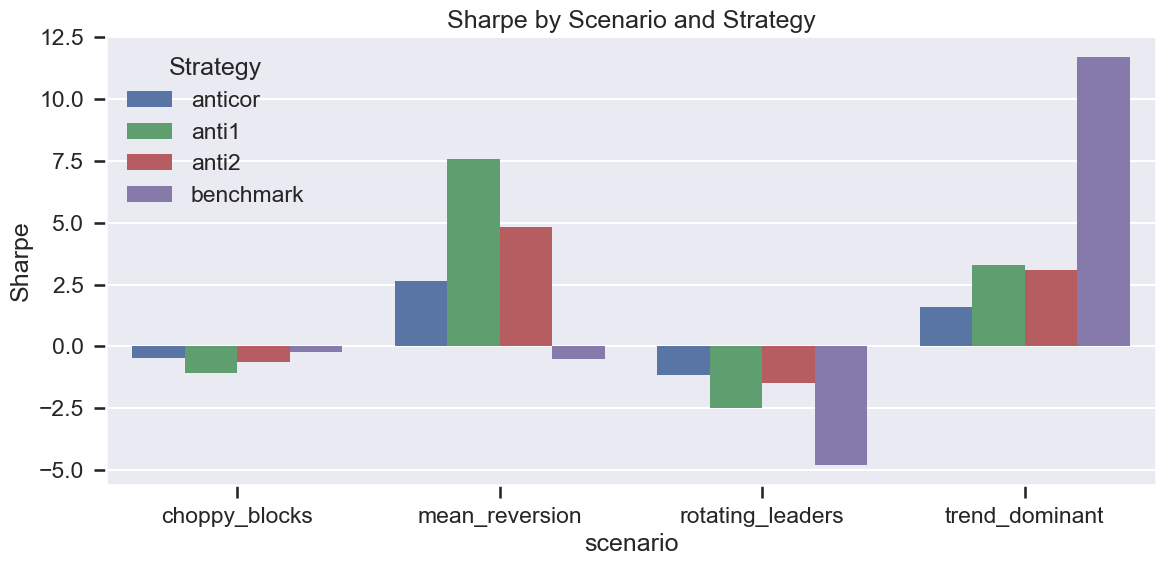

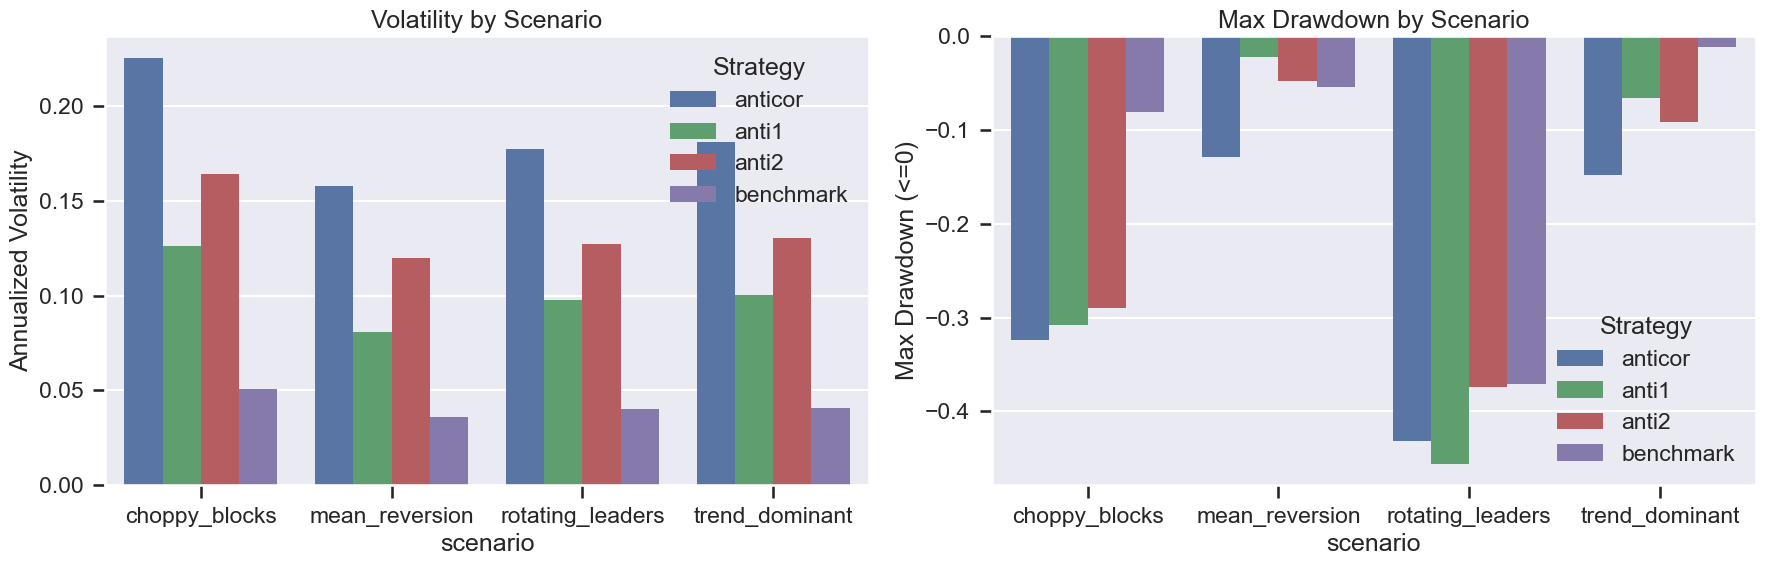

Rendered comparison plots inline.


In [49]:
# 7. Sharpe / Volatility / Drawdown Comparison Plots
sns.set_context("talk")

# Sharpe by scenario
fig1, ax1 = plt.subplots(figsize=(12, 6))
plot_df = scenario_compact.reset_index().melt(
    id_vars=["scenario"],
    value_vars=[f"{s}_sharpe_mean" for s in STRATEGIES],
    var_name="strategy",
    value_name="sharpe",
)
plot_df["strategy"] = plot_df["strategy"].str.replace("_sharpe_mean", "")
sns.barplot(data=plot_df, x="scenario", y="sharpe", hue="strategy", ax=ax1)
ax1.set_title("Sharpe by Scenario and Strategy")
ax1.set_ylabel("Sharpe")
ax1.legend(title="Strategy")
fig1.tight_layout()
plt.show()

# Risk (Volatility & Drawdown) side-by-side
fig2, axes = plt.subplots(1, 2, figsize=(18, 6))
vol_df = scenario_compact.reset_index().melt(
    id_vars=["scenario"],
    value_vars=[f"{s}_volatility_mean" for s in STRATEGIES],
    var_name="strategy",
    value_name="volatility",
)
vol_df["strategy"] = vol_df["strategy"].str.replace("_volatility_mean", "")
sns.barplot(data=vol_df, x="scenario", y="volatility", hue="strategy", ax=axes[0])
axes[0].set_title("Volatility by Scenario")
axes[0].set_ylabel("Annualized Volatility")
axes[0].legend(title="Strategy")

dd_df = scenario_compact.reset_index().melt(
    id_vars=["scenario"],
    value_vars=[f"{s}_max_drawdown_mean" for s in STRATEGIES],
    var_name="strategy",
    value_name="max_drawdown",
)
dd_df["strategy"] = dd_df["strategy"].str.replace("_max_drawdown_mean", "")
sns.barplot(data=dd_df, x="scenario", y="max_drawdown", hue="strategy", ax=axes[1])
axes[1].set_title("Max Drawdown by Scenario")
axes[1].set_ylabel("Max Drawdown (<=0)")
axes[1].legend(title="Strategy")
fig2.tight_layout()
plt.show()

print("Rendered comparison plots inline.")

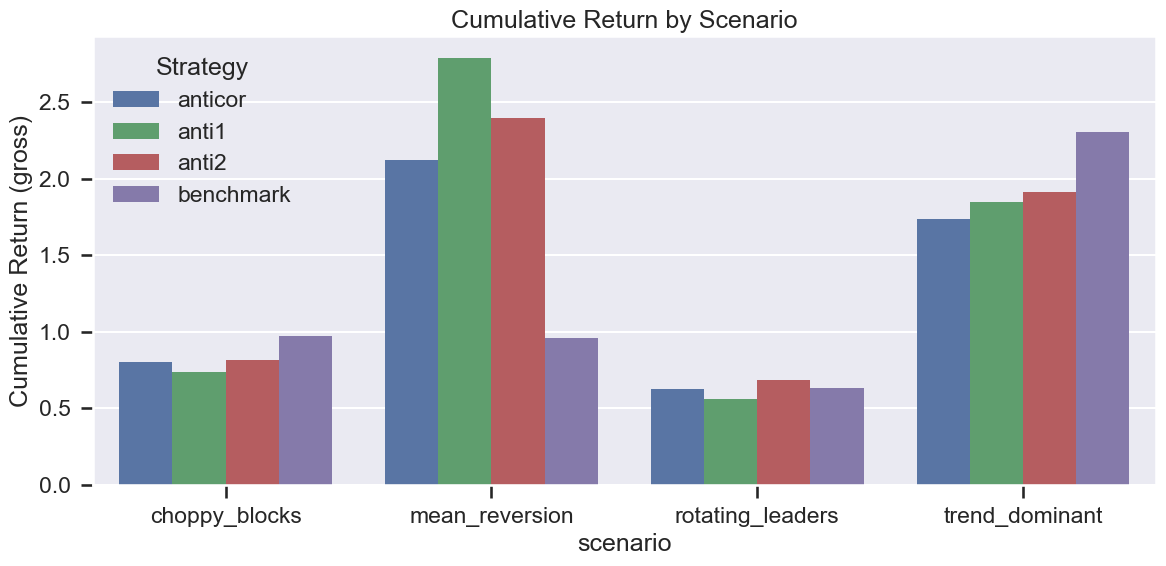

Rendered cumulative return plot inline (if generated).


In [50]:
# 8. Cumulative Return Comparison Plots
fig3, ax3 = plt.subplots(figsize=(12, 6))
cumret_df = scenario_compact.reset_index().melt(
    id_vars=["scenario"],
    value_vars=[f"{s}_cumulative_return_mean" for s in STRATEGIES if f"{s}_cumulative_return_mean" in scenario_compact.columns],
    var_name="strategy",
    value_name="cumulative_return",
)
if not cumret_df.empty:
    cumret_df["strategy"] = cumret_df["strategy"].str.replace("_cumulative_return_mean", "")
    sns.barplot(data=cumret_df, x="scenario", y="cumulative_return", hue="strategy", ax=ax3)
    ax3.set_title("Cumulative Return by Scenario")
    ax3.set_ylabel("Cumulative Return (gross)")
    ax3.legend(title="Strategy")
    fig3.tight_layout()
    plt.show()
else:
    print("Cumulative return columns not found in compact summary; skipping plot.")

print("Rendered cumulative return plot inline (if generated).")

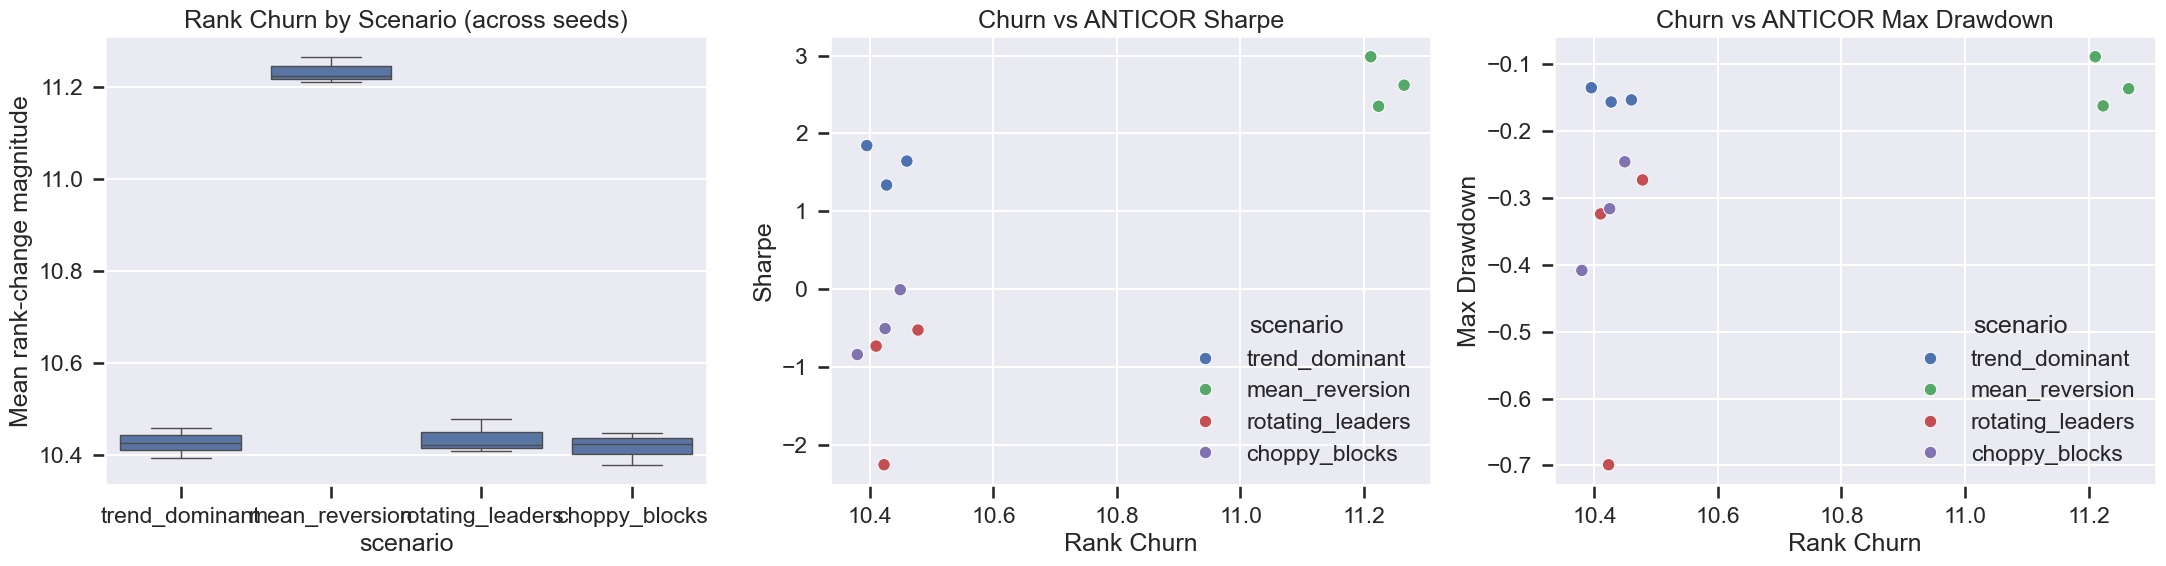

Rendered rank churn analysis inline.


In [51]:
# 9. Rank Churn Analysis
fig4, axes = plt.subplots(1, 3, figsize=(22, 6))
# Boxplot of rank_churn by scenario
sns.boxplot(data=metrics_csv, x="scenario", y="rank_churn", ax=axes[0])
axes[0].set_title("Rank Churn by Scenario (across seeds)")
axes[0].set_ylabel("Mean rank-change magnitude")

# Correlation: churn vs Sharpe (ANTICOR)
sh_df = metrics_csv[["scenario", "rank_churn", "anticor_sharpe"]].copy()
sns.scatterplot(data=sh_df, x="rank_churn", y="anticor_sharpe", hue="scenario", ax=axes[1])
axes[1].set_title("Churn vs ANTICOR Sharpe")
axes[1].set_xlabel("Rank Churn")
axes[1].set_ylabel("Sharpe")

# Correlation: churn vs Drawdown (ANTICOR)
dd_df = metrics_csv[["scenario", "rank_churn", "anticor_max_drawdown"]].copy()
sns.scatterplot(data=dd_df, x="rank_churn", y="anticor_max_drawdown", hue="scenario", ax=axes[2])
axes[2].set_title("Churn vs ANTICOR Max Drawdown")
axes[2].set_xlabel("Rank Churn")
axes[2].set_ylabel("Max Drawdown")

fig4.tight_layout()
plt.show()

print("Rendered rank churn analysis inline.")

In [52]:
# 10. Export Styled Tables and Figures (Disabled)
# This notebook is the final output. No external files are written.
print("Skipping external exports; all outputs rendered inline.")

Skipping external exports; all outputs rendered inline.
